# Stacking Example
------------------

#### <font color="blue"> by: Jeremy Meinke (feel free to contact me here on GitHub, LinkedIn, or email)
------------------------------------------

This notebook will outline the various maps and stacking code that I've built (and now cleaned up for you).  

It is by no mean a comprehensive and fully-optimized pipeline, but combined with the other notebooks, these should encompass most of the work that I've done.

The goal of everything here is to:
1.  Show a good summary of my work conducted.
2.  Provide others (future grad students or general astrophysics audience) with code that can be the foundation for even cooler analysis!

---


To start with, we'll load up the SPT-SZ Cluster Catalog.  For convenience, you can use the shell scripts in ./data/ to download any files I'll show here.  

In ./data/ terminal, run "bash pull_spt_cluster_catalog_2019_wget.sh"  You'll want to do the same for the other scripts as well according to which code blocks you want to run.

(inspect code further below to check where they are used)

Done? Okay:

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from astropy.table import Table
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
from pixell import enmap
from cycler import cycler
import time
import gc  
###SPT maps are big... gc.collect() is a safety way to try to keep the notebook from using too much memory
import h5py

from stacking_code import stacking    ###My stacking code
from analysis_code import general     ###My general analysis code

###My personal matplotlib preferences
marker_cycle=["o","^","s","d","X","2","h","v",">"]
color_cycle=["k","b","r","c","orange","m","lime","grey","lavender"]
mpl.rcParams["axes.prop_cycle"] = cycler(color=color_cycle + color_cycle[::-1], marker=marker_cycle*2)

print("Last time run: %s"%time.asctime())


Last time run: Mon Jan 30 16:07:52 2023


Now reading the cluster catalog and into a pandas table:

In [2]:
catalog = Table.read("./data/2500d_cluster_sample_Bocquet19.fits", format="fits").to_pandas()
print("Table Columns: \n", list(catalog.columns))
###A quick declination cut to ensure all of these overlap with the ACT maps (I chose -60 to avoid some noisy ACT data that occurs from -60 to -63)
catalog = catalog[catalog["DEC"] >= -60]
cat_len = len(catalog)
print("\nCatalog size: ", cat_len)
# print(catalog)    ###To view what each column looks like

Table Columns: 
 ['SPT_ID', 'RA', 'DEC', 'FIELD', 'XI', 'THETA_CORE', 'YSZ', 'DYSZ', 'REDSHIFT', 'REDSHIFT_UNC', 'REDSHIFT_LIMIT', 'XRAY', 'SPECZ', 'WEAK_LENSING', 'M500', 'M500_uerr', 'M500_lerr', 'M200', 'M200_uerr', 'M200_lerr', 'M500_marge', 'M500_marge_uerr', 'M500_marge_lerr', 'M200_marge', 'M200_marge_uerr', 'M200_marge_lerr']

Catalog size:  574


Now selecting the RAs and DECs of our catalog

In [3]:
catalog_ra = catalog["RA"]
catalog_dec = catalog["DEC"]

### Next Step: Load Map (SPT 95 GHz)
##### *Note*: 
My healpix map loading code, i.e. using stacking.map_data_healpix_fits(file_name), uses healpy.read_map() as the default.  *However* I've noticed loading the SPT-SZ maps, which are ~3 GB, for some reason uses all 16GB of my memory...  likely something to do with either the .fits file header or healpy.read_map() function.

This memory issue can be avoided by calling stacking.map_data_healpix_fits(file_name, unreadable_header = True), as I have "unreadable_header = True" instead use astropy.io.fits.open(file_name).  The other option is to use alm files if provided (SPT does provide those, see shell script), i.e. stacking.map_data_healpix_fits(file_name, healpix_alm = True)

***

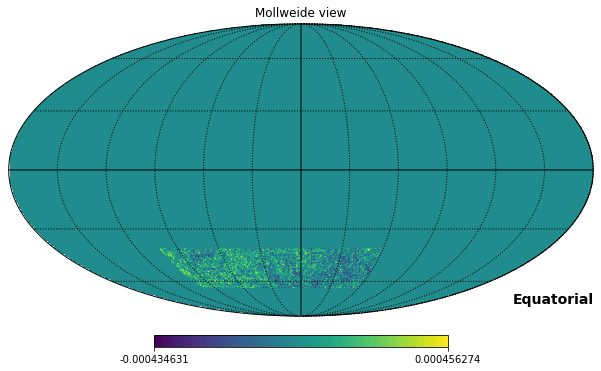

In [4]:
###Here I use unreadable_header = True to avoid whatever that memory issue is
spt_map = stacking.map_data_healpix_fits("./data/combined_map_95GHz_nside8192_ptsrcmasked_50mJy.fits", unreadable_header=True)
### you could also do the alm method (This may cause your CPU to run at 100% for a minute or so...):
# spt_map = stacking.map_data_healpix_fits("./data/alm_combined_data_95GHz_ptsrcmasked_50mJy.fits", healpix_alm = True)

hp.mollview(spt_map, coord="C")    ###Coord = "C" just tells it the map is celestial/equatorial (puts label on plot)
hp.graticule()
plt.show()

###It may throw some warnings from healpy (depending on version) using soon-to-be depreciated matplotlib features

Now we want to do some stacking of the cluster catalog:

Start Time:  Mon Jan 30 16:08:19 2023
Catalog length: 574
Post-Stack Time:  Mon Jan 30 16:08:21 2023


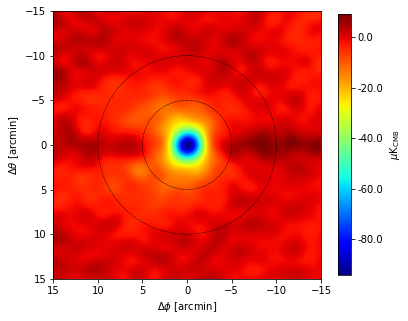

In [5]:
pix_res = 0.2
side_arcmin = 30
micro_K_correction = 1e6	###to convert from units of K to uK
###With interpolation
spt_95_interp = stacking.stack(spt_map, catalog_ra.to_numpy(), catalog_dec.to_numpy(), side_arcmin, pix_res, interpolate=True)
###Note: you technically don't really need the .to_numpy() here, but only because the catalog's pandas table has default row numbering

###now let's average, convert to uK and remove any large foreground gradient/mean
spt_95_interp = general.remove_gradient(spt_95_interp * micro_K_correction / cat_len, pix_res=pix_res, center_cut_dist=10)	
###here we choose to ignore the pixels within 10 arcmin, really just because I know most of the pixels outside 10 arcmin are negligible/should contain minimal signal

###now let's plot this:
general.single_stack_plot(spt_95_interp, pix_res, circle_arcs=[5, 10])

Start Time:  Mon Jan 30 16:08:21 2023
Catalog length: 574
Post-Stack Time:  Mon Jan 30 16:08:23 2023


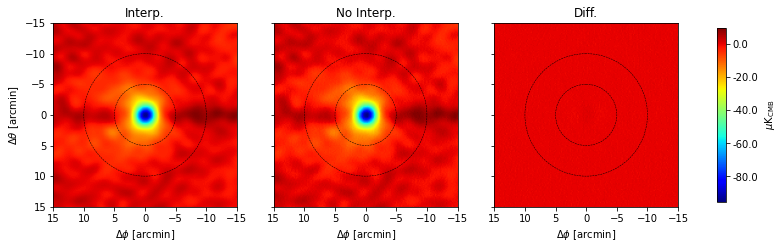

In [6]:
###And without interpolation: (less noticeable with the larger the sample)
spt_95 = stacking.stack(spt_map, catalog_ra.to_numpy(), catalog_dec.to_numpy(), side_arcmin, pix_res, interpolate = False)

###Or see what happens when you shift this one off-center some
#spt_95 = stacking.stack(spt_map, catalog_ra.to_numpy()-.1, catalog_dec.to_numpy()-.1, side_arcmin, pix_res, interpolate = False)

spt_95 = general.remove_gradient(spt_95 * micro_K_correction / cat_len, pix_res=pix_res, center_cut_dist=10)

###Now plot them together with their difference
general.multi_stack_plot([spt_95_interp, spt_95, spt_95_interp - spt_95], pix_res, sub_titles=["Interp.", "No Interp.", "Diff."], circle_arcs=[5, 10])


Note how there is minimal difference.  With a zoomed in colorbar, you may be able to discern some pixel-by-pixel noise differences.

### Radial Profile

Now, before we look at the other frequencies, let"s "stack" the radial profiles into a table as well:

In [7]:
radial_edges = np.arange(0,15.01,0.5)
spt_95_interp_radial = stacking.stack_radial_avg(spt_map, catalog_ra.to_numpy(), catalog_dec.to_numpy(), radial_edges, pix_res)

###And showing resultant table:
print(spt_95_interp_radial)

Start Time:  Mon Jan 30 16:08:23 2023
Catalog length: 574
side arc check:  32.0
cutout size and number of apertures:  (161, 161) 30
Post-Stack Time:  Mon Jan 30 16:08:27 2023
     0.00 to 0.50 [Arcmin]  0.50 to 1.00 [Arcmin]  1.00 to 1.50 [Arcmin]  \
0                -0.000012              -0.000008               0.000003   
1                -0.000116              -0.000112              -0.000099   
2                -0.000006              -0.000006              -0.000006   
3                -0.000159              -0.000152              -0.000134   
4                -0.000075              -0.000066              -0.000050   
..                     ...                    ...                    ...   
569              -0.000082              -0.000074              -0.000062   
570              -0.000045              -0.000044              -0.000035   
571              -0.000035              -0.000031              -0.000026   
572              -0.000086              -0.000077              -0

In [8]:
###Now the non-interpolated version:
spt_95_radial = stacking.stack_radial_avg(spt_map, catalog_ra.to_numpy(), catalog_dec.to_numpy(), radial_edges, pix_res, interpolate=False)

Start Time:  Mon Jan 30 16:08:27 2023
Catalog length: 574
side arc check:  32.0
cutout size and number of apertures:  (161, 161) 30
Post-Stack Time:  Mon Jan 30 16:08:30 2023


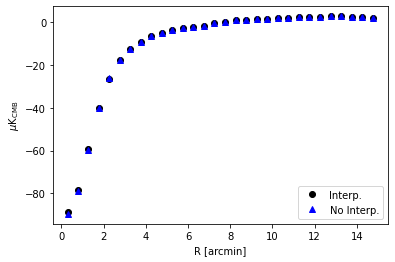

In [9]:
###And plot the average:
radial_centers = 2 / 3 * (radial_edges[1:]**3 - radial_edges[:-1]**3) / (radial_edges[1:]**2 - radial_edges[:-1]**2)	###True radial center between edges (since 2d radius)
###plt.plot instead of plt.scatter here bc scatter seems to ignore cycle(marker)
plt.plot(radial_centers, np.mean(spt_95_interp_radial, axis=0) * micro_K_correction, label="Interp.", linestyle="")
plt.plot(radial_centers, np.mean(spt_95_radial, axis=0) * micro_K_correction, label="No Interp.", linestyle="")
plt.xlabel("R [arcmin]")
plt.ylabel(r"$\mu$K$_{\rm CMB}$")
plt.legend()
plt.show()


### Onto other SPT frequencies!
(To keep memory within limits, we will replace the 95 GHz map with each subsequent one)

In [10]:
###clearing precaution
spt_map = None; del spt_map
gc.collect()
###150 GHz
spt_map = stacking.map_data_healpix_fits("./data/combined_map_150GHz_nside8192_ptsrcmasked_50mJy.fits", unreadable_header=True)
###Stacking
spt_150_interp = stacking.stack(spt_map, catalog_ra.to_numpy(), catalog_dec.to_numpy(), side_arcmin, pix_res, interpolate=True)
spt_150_interp = general.remove_gradient(spt_150_interp * micro_K_correction / cat_len, pix_res=pix_res, center_cut_dist=10)	
spt_150_interp_radial = stacking.stack_radial_avg(spt_map, catalog_ra.to_numpy(), catalog_dec.to_numpy(), radial_edges, pix_res)

Start Time:  Mon Jan 30 16:08:56 2023
Catalog length: 574
Post-Stack Time:  Mon Jan 30 16:08:58 2023
Start Time:  Mon Jan 30 16:08:58 2023
Catalog length: 574
side arc check:  32.0
cutout size and number of apertures:  (161, 161) 30
Post-Stack Time:  Mon Jan 30 16:09:02 2023


In [11]:
###clearing precaution
spt_map = None; del spt_map
gc.collect()
###220 GHz
spt_map = stacking.map_data_healpix_fits("./data/combined_map_220GHz_nside8192_ptsrcmasked_50mJy.fits", unreadable_header=True)
###Stacking
spt_220_interp = stacking.stack(spt_map, catalog_ra.to_numpy(), catalog_dec.to_numpy(), side_arcmin, pix_res, interpolate=True)
spt_220_interp = general.remove_gradient(spt_220_interp * micro_K_correction / cat_len, pix_res=pix_res, center_cut_dist=10)	
spt_220_interp_radial = stacking.stack_radial_avg(spt_map, catalog_ra.to_numpy(), catalog_dec.to_numpy(), radial_edges, pix_res)

###clearing precaution
spt_map = None; del spt_map
gc.collect()

Start Time:  Mon Jan 30 16:09:28 2023
Catalog length: 574
Post-Stack Time:  Mon Jan 30 16:09:30 2023
Start Time:  Mon Jan 30 16:09:30 2023
Catalog length: 574
side arc check:  32.0
cutout size and number of apertures:  (161, 161) 30
Post-Stack Time:  Mon Jan 30 16:09:34 2023


0

### Now showing them all together:

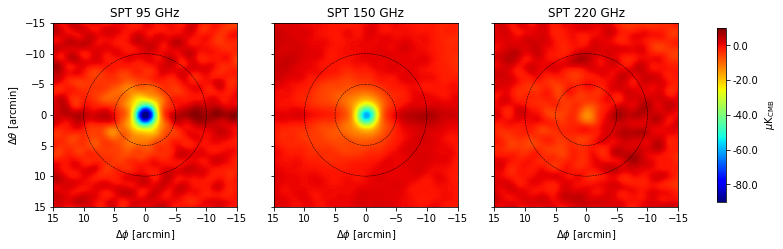

In [12]:
###Stamp Cutouts
general.multi_stack_plot([spt_95_interp, spt_150_interp, spt_220_interp], pix_res, sub_titles=["SPT 95 GHz", "SPT 150 GHz", "SPT 220 GHz"], circle_arcs=[5, 10], cbar_bounds=[-90, 10])

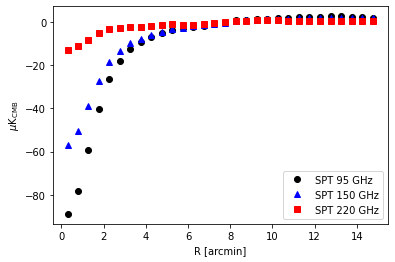

In [13]:
###Radial profiles

plt.plot(radial_centers, np.mean(spt_95_interp_radial, axis=0) * micro_K_correction, label="SPT 95 GHz", linestyle="")
plt.plot(radial_centers, np.mean(spt_150_interp_radial, axis=0) * micro_K_correction, label="SPT 150 GHz", linestyle="")
plt.plot(radial_centers, np.mean(spt_220_interp_radial, axis=0) * micro_K_correction, label="SPT 220 GHz", linestyle="")
plt.xlabel("R [arcmin]")
plt.ylabel(r"$\mu$K$_{\rm CMB}$")
plt.legend()
plt.show()

Interpretation 
--------------

Now, this was just a quick example of the code.  Uncertainties would still need to be calculated, likely through bootstrap resampling or mock models of the sky.  The horizontal line evident in the 95 and 150 GHz stacked images may be evident of a map effect, such as their rough removal of point sources or proximity to the edge of the SPT field/map.  Or simply neighboring structures since the sample size is quite small.  The slight negative signal in 220 GHz also seems to indicate a non-tSZ signal (as the tSZ null frequency is at 217 GHz).  Possible the fainter kinetic Sunyaev-Zel'dovich effect since we are looking at large clusters.

---

I have included the SPT bandpasses that I used.  *However, note that they are simply extracted from the plot in SPT-SZ Chown et al. 2018, and not the official exact values* (but should contain differences small enough to be negligible).

Meanwhile, the ACT bandpasses are available publicly and can be downloaded via the ACT DR5 auxilliary shell script.

In [14]:
###SPT Bandpasses
spt_freqs = [95, 150, 220]
spt_bp_name = "GHz_SPT_Filter.txt"
spt_bandpasses = [np.genfromtxt("./data/" + str(f) + spt_bp_name) for f in spt_freqs]

###Loading the ACT Bandpasses (provided and pulled from the LAMBDA NASA website).  Here they are provided 
act_freqs = [90, 150, 220]
act_bp = h5py.File("./data/act_dr5.01_auxilliary/act_planck_dr5.01_s08s18_bandpasses_scaledep.hdf")
act_bp_keys = list(act_bp.keys())
print(act_bp_keys)
for a in act_bp_keys:
	print(a, act_bp[a].shape)

act_bp_bandpasses = np.asarray(act_bp["bandpass"])
print(act_bp_bandpasses.shape)	###The first index is size 2 due to ivar and ivar uncertainty
act_bp_freqs = np.asarray(act_bp["freqs"])
print(act_bp_freqs.shape)

['arrays', 'bandpass', 'freqs', 'ls']
arrays (15,)
bandpass (2, 15, 50, 434)
freqs (434,)
ls (50,)
(2, 15, 50, 434)
(434,)


Since ACT bandpasses are given over each detector/instrument array, frequency, and ls, we can (and advised by the ACT repo) create inverse-variance weighted bandpasses for whatever use we need.  For SZ stacking, this mostly involves making a low-ell cut (and a max ell cut at 10,000 if comparing to SPT) and weighting over just our field of interest.

In [15]:
###The third index is multipole ells (ls) angular scales, which we may want to cut
act_ells = act_bp[act_bp_keys[3]][...]

###Making a box along the act field for the operating range we used
act_box = [np.deg2rad([-62,-62]),np.deg2rad([-38,107])]	###2 deg padding

###Now over each frequency, load fullivar
act_full_band = []
act_2000_ell_cut = []			###For 2000 < ell
act_2000_sptmax_ell_cut = []	###For 1000 < ell < 10,000
for f in range(3):
	###Where sel=0 selects the I (temperature) map (1 == Q, 2 == U polarization maps).  This helps reduce memory by selecting only what we care about.
	act_noise_box = enmap.read_map("./data/act_planck_dr5.01_s08s18_AA_f%s_daynight_fullivar.fits"%str(act_freqs[f]).zfill(3), sel=0, box=act_box)
	###Sum over all RA and DEC
	act_noise_box = np.sum(act_noise_box, axis=(2, 3))
	###Normalize
	act_weights = act_noise_box / np.sum(act_noise_box)

	###Get bandpasses
	act_full_band.append(np.sum(act_weights[:, :, None] * act_bp_bandpasses[0][0:,:,:], axis=(0, 1)))
	act_2000_ell_cut.append(np.sum(act_weights[:, 2000 < act_ells, None] * act_bp_bandpasses[0][0:, 2000 < act_ells,:], axis=(0, 1)))
	act_2000_sptmax_ell_cut.append(np.sum(act_weights[:, (2000 < act_ells) & (act_ells <= 10000), None] * act_bp_bandpasses[0][0:, (2000 < act_ells) & (act_ells <= 10000),:], axis=(0, 1)))

act_noise_box = None; del act_noise_box
gc.collect()

5651

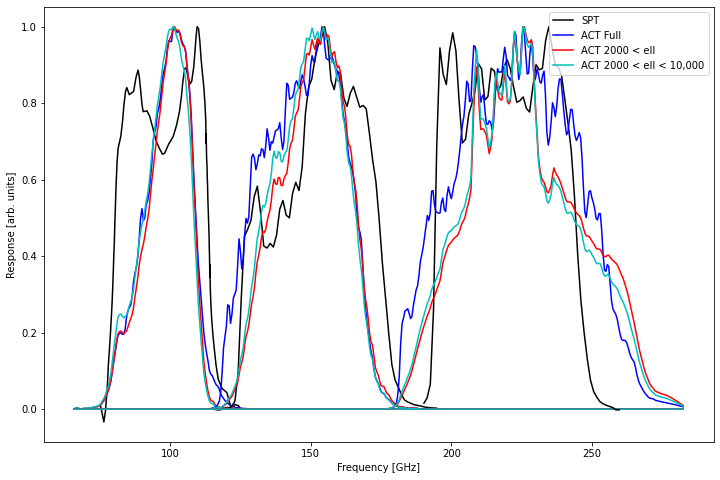

In [16]:
###Now plotting all the bandpasses:
plt.figure(figsize=(12, 8))
for f in range(3):
	###SPT
	plt.plot(spt_bandpasses[f][:,0], spt_bandpasses[f][:,1]/np.max(spt_bandpasses[f][:,1]), marker="", color=color_cycle[0])
	###ACT (no ell cut)
	plt.plot(act_bp_freqs, act_full_band[f]/np.max(act_full_band[f]), marker="", color=color_cycle[1])
	###ACT (low ell cut)
	plt.plot(act_bp_freqs, act_2000_ell_cut[f]/np.max(act_2000_ell_cut[f]), marker="", color=color_cycle[2])
	###ACT (low and high ell cut)
	plt.plot(act_bp_freqs, act_2000_sptmax_ell_cut[f]/np.max(act_2000_sptmax_ell_cut[f]), marker="", color=color_cycle[3])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Response [arb. units]")
plt.legend(["SPT", "ACT Full", "ACT 2000 < ell", "ACT 2000 < ell < 10,000"])
plt.show()


The above plot displays the frequency response for SPT and ACT instruments.  Three different versions of ACT are shown: *blue* shows for their entire ACT+Planck maps; *red* shows with a low multipole ell cut (below 2,000) which removes affects at large-scales (> ~5 arcmin); and finally *cyan* showing an additional high ell cut (above 10,000) to reflect the same cut that SPT data is provided in.

Also note how the SPT 220 GHz band (black) may indeed be slightly skewed to below the 217 GHz tSZ null frequency.

### ACT Stacking

Now I'll also quickly show similar stacking for the ACT+Planck daynight srcfree maps:

In [17]:
###ACT map loading and image stacking
act_90_interp = act_150_interp = act_220_interp = None	###This crafty way of keeping a nice for loop requires defining these first, or else VS code will tell me there's an error...
for f in act_freqs:
	###Where sel=0 selects the I (temperature) map (1 == Q, 2 == U polarization maps).  This helps reduce memory by selecting only what we care about.
	act_map = stacking.map_data_pixell_fits("./data/act_planck_dr5.01_s08s18_AA_f%s_daynight_map_srcfree.fits"%str(f).zfill(3), sel=0, box=act_box)
	print(act_map.shape)	###Check
	exec("act_%i_interp = stacking.stack(act_map, catalog_ra.to_numpy(), catalog_dec.to_numpy(), side_arcmin, pix_res, plate_carree=True, interpolate=True)"%f)
	exec("act_%i_interp = general.remove_gradient(act_%i_interp / cat_len, pix_res=pix_res, center_cut_dist=10)"%(f, f))

# ###clearing precaution
act_map = None; del act_map
gc.collect()


(2880, 20280)
Start Time:  Mon Jan 30 16:10:09 2023
Catalog length: 574
Post-Stack Time:  Mon Jan 30 16:10:11 2023
(2880, 20280)
Start Time:  Mon Jan 30 16:10:22 2023
Catalog length: 574
Post-Stack Time:  Mon Jan 30 16:10:24 2023
(2880, 20280)
Start Time:  Mon Jan 30 16:10:36 2023
Catalog length: 574
Post-Stack Time:  Mon Jan 30 16:10:38 2023


4509

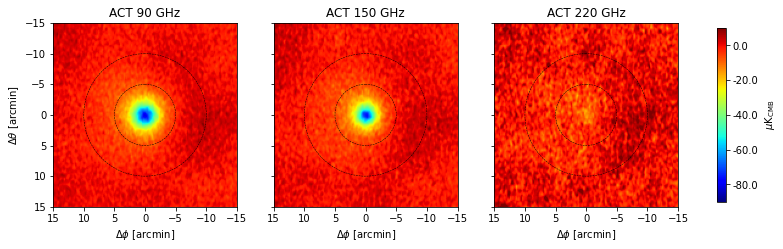

In [18]:
###Now put all the ACT stamps together just like SPT:
general.multi_stack_plot([act_90_interp, act_150_interp, act_220_interp], pix_res, sub_titles=["ACT 90 GHz", "ACT 150 GHz", "ACT 220 GHz"], circle_arcs=[5, 10], cbar_bounds=[-90, 10])


These ACT stacks look very similar to SPT, as they should.  The main differences may arise from their different beams (they are provided as: SPT == 1.85 arcmin, vs ACT == freq. depedent 2.1/1.3/1.0 arcmin), and differences in point source removal (SPT just makes 5 arcmin circular cuts, ACT tries a fit and remove method)

ACT should look a bit more pixelated.  That is likely a result mostly from their inclusion of multipoles up to 20,000 (SPT only goes to 10,000), along with their choice in Plate-Carree (CAR) projection that naturally aranges pixels in a grid-like fashion.

## Final Comments

Here I've shown the general methods and functions I've used in stacking of mm-telescope maps.  More detailed map operations, such as modifying maps in spherical harmonic space, I leave for you or a future notebook.  I will be including one additional notebook detailing a bit more of the analysis functions of mine.  Particularly my Bayesian estimator function fitting procedure.

There is also the "./hpc_stacking_example/" folder, in which I outline my process in running this type of stacking code in the ASU *agave* HPC cluster.  Such resources proved extremely helpful, especially when stacking upwards of 400,000 galaxies.